# Appendix 1c. RMEstimator test with mock data - analysis

**Author: [Hannu Parviainen](mailto:hpparvi@gmail.com)** </br>
**Last edited: 19 September 2023**


In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [32]:
from warnings import catch_warnings, simplefilter
from pathlib import Path
from corner import corner
from arviz.stats import kde
from spright.rmrelation import RMRelation

In [146]:
files = {}
for f in  sorted(Path('.').glob('mock*.fits')):
    l = f.name.split('_')
    psize = int(l[1][2:])
    ws = int(l[2][3:])
    batch = int(l[3][1])
    files[psize, ws, batch] = f

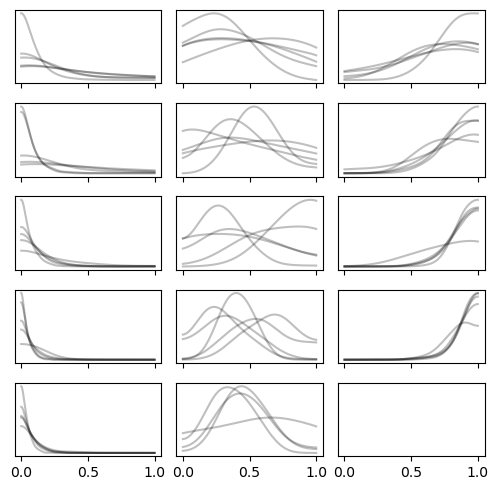

In [147]:
fig, axs = subplots(5, 3, figsize=(5,5), sharex='all')
ixs = {50:0, 75:1, 100:2, 150:3, 200:4}
iys = {0:0, 50:1, 100:2}
with catch_warnings():
    simplefilter('ignore')
    for (psize, ww, batch),f in files.items():
        rmr = RMRelation(f)
        x, y = kde(rmr.posterior_samples.ww.values, custom_lims=(0,1), bw_fct=3)
        ax = axs[ixs[psize], iys[ww]]
        ax.plot(x, y, 'k', alpha=0.25)
setp(axs, yticks=[])
fig.tight_layout()

---

<center>
©2023 Hannu Parviainen
</center>